In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats
from os.path import isdir, isfile, join
from os import makedirs
from scipy.stats import levy_stable
from scipy.stats import multivariate_normal
from matplotlib.cm import get_cmap
from matplotlib.transforms import ScaledTranslation
from string import ascii_lowercase
from scipy.optimize import brentq
from scipy.special import gamma, hyp1f1
from sklearn.metrics import pairwise_distances
from tqdm import tqdm

# local and non-local kernels
def fdm_kernel(g_dist, alpha, d_intrinsic, bandwidth=1, is_rescaled_dist=False):

    if is_rescaled_dist:
        g_dist = g_dist / d_intrinsic**0.5

    if alpha < 2:
        #attn_score = (1 + g_dist / head_dim**0.5 / bandwidth**0.5)**(-d_intrinsic-alpha)
        attn_score = (1 + g_dist / bandwidth**0.5)**(-d_intrinsic-alpha)
    else:
        #attn_score = torch.exp(-(g_dist / head_dim**0.5 / bandwidth**0.5)**(alpha/(alpha-1)))
        #attn_score = torch.exp(-(g_dist / bandwidth**0.5)**(alpha/(alpha-1)))
        attn_score = np.exp(-(g_dist / bandwidth**0.5)**(alpha/(alpha-1)))

    return attn_score

def get_markov_matrix(C, alpha, bandwidth, d, a):

    #sphere_radius = ((np.pi**(1/d)-1)/np.pi)
    if alpha >= 2:
        alpha_hat = alpha/(alpha-1)
        K = np.exp(-(C/bandwidth**0.5)**alpha_hat)
    else:
        K = (1 + C/bandwidth**0.5)**(-d-alpha)

    D = K.sum(-1)  # row normalization
    if a == 0:
        K_tilde = K
    else:
        K_tilde = np.diag(D**(-a)) @ K @ np.diag(D**(-a))
    D_tilde = K_tilde.sum(-1)

    #return np.diag(D_tilde**(-1)) @ K_tilde
    return K, D, K_tilde, D_tilde

/tmp/ipython-input-3833917938.py:51: RuntimeWarning: invalid value encountered in arccos
  g_dists_2 = np.arccos(uniform_xys @ uniform_xys.T)
/tmp/ipython-input-3833917938.py:89: RuntimeWarning: invalid value encountered in log
  eigvals_transformed = -1/t * np.log(eigvals)


alpha = 1.2
M min: 3.1226182999645516e-05, max: 0.9814328598656848
K min: 4.6540643614637834e-05, max: 1.0
K_tilde min: 4.6540643614637834e-05, max: 1.0


alpha = 2
M min: 2.4594933403604354e-203, max: 0.9999998964097728
K min: 4.7224036709989946e-203, max: 1.0
K_tilde min: 4.7224036709989946e-203, max: 1.0




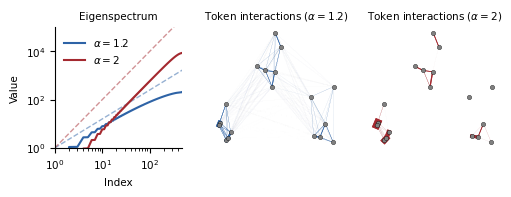

In [ ]:
np.random.seed(seed=2)

BIGGER_SIZE = 7.5
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
MARKERSIZE = 10
LWIDTH = 4
# plt.rcParams["font.family"] = "sans-serif"

alpha = 1.2
alphas_selected = [alpha, 2]

# color scheme 2
# HYP_CM = 'turbo'
# HYP_CMAP = get_cmap(HYP_CM)
# HYP_CNORM = mpl.colors.Normalize(vmin=1, vmax=2)
COLORS_ALPHA = ["#636363", "#469C76", "#2E63A6", "#C17DA5", "#C66526", "#EEE461", "#A4292F"]

# Create figure and subplots
nrows, ncols = 1, 3
fig, axes = plt.subplots(nrows, ncols)  #  gridspec_kw={'wspace': 0.3, 'hspace': 0.3}
fig.set_size_inches(5.1,2)
axes = axes[None,:]

# subfigure labels
# ii_subfigs = 0
# for i in range(nrows):
#     for j in range(ncols):
#         ax = axes[i,j]
#         ax.text(-0.16, 1.0, f'({ascii_lowercase[ii_subfigs]})', transform=(
#         ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
#         va='bottom')  # , fontfamily='sans-serif'
#         ii_subfigs += 1



##### a #####

# Sample 1 (2D uniform grid large)

ax = axes[0,0]

uniform_sample_size = 500
uniform_radians = np.linspace(0,2*np.pi,uniform_sample_size)
uniform_xys = np.stack([np.cos(uniform_radians), np.sin(uniform_radians)]).T
g_dists_2 = np.arccos(uniform_xys @ uniform_xys.T)

alphas1 = [1.2, 2]
#alphas1 = [1.2, 1.6, 2]
a = 0
bandwidth1 = 1e-4
n = g_dists_2.shape[0]
d = 1

# hard set distance along diagonals to be zero
for ii in range(n):
    g_dists_2[ii,ii] = 0

idxs = np.arange(1,uniform_sample_size+1)
idx_mid = int(n/2)

for aidx, alpha in enumerate(alphas_selected):

    # c_alpha = HYP_CMAP(HYP_CNORM(alpha))
    c_alpha = COLORS_ALPHA[round((alpha - 1)/0.2) + 1]

    t = bandwidth1**(alpha/2)
    K, D, K_tilde, D_tilde = get_markov_matrix(g_dists_2, alpha, bandwidth1, d, a)

    # ---------- Eigvals ----------
    if a == 0:
        K, D, K_tilde, D_tilde = get_markov_matrix(g_dists_2, alpha, bandwidth1, d, a)
        K_hat = np.diag(D_tilde**(-1/2)) @ K_tilde @ np.diag(D_tilde**(-1/2))
        K_hat_sym = 0.5*(K_hat + K_hat.T)

        eigvals, eigvecs = np.linalg.eigh(K_hat_sym)
        eigvecs_transformed = np.diag(D_tilde**(-0.5)) @ eigvecs

        # eigvals
        eidx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[eidx]; eigvecs = eigvecs[:,eidx]

        # transformation for operator
        eigvals_transformed = -1/t * np.log(eigvals)
        # eye guide
        power = alpha if alpha < 2 else 2
        # power = alpha/2 if alpha < 2 else 2
        eigvals_theory = idxs**power
        # eigvals_theory = eigvals_theory / eigvals_theory[idx_mid]
        # eigvals_theory = eigvals_theory * eigvals[idx_mid] * 10

        ax.plot(idxs, eigvals_transformed, c=c_alpha, label=rf'$\alpha = {{{alpha}}}$')
        ax.plot(idxs, eigvals_theory, c=c_alpha, alpha=0.5, linewidth=1, linestyle='--')

        ax.set_xlim([1, n - 30])
        if d == 1:
            #ax.set_ylim([1, 1e6])
            ax.set_ylim([1, 1e5])
        ax.set_xscale('log'); ax.set_yscale('log')

ax.tick_params(axis='both', which='minor')
ax.legend(frameon=False)
ax.set_title('Eigenspectrum')
ax.set_xlabel('Index')
ax.set_ylabel('Value')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

##### b, c #####

# Define parameters for the multi-modal Gaussian distribution
means = np.array([[3, 0], [-3, 0], [0, np.sqrt(3)]])
sigma = 0.25
cov = [[sigma, 0], [0, sigma]]  # Isotropic covariance (same for both components)
total_means = means.shape[0]

# Create the 2D Gaussian distributions
rv_dists = []
for idx in range(total_means):
    rv_dists.append(multivariate_normal(means[idx], cov))

# Number of samples per mode
# samples_per_mode = 7
samples_per_mode = 6
num_samples = total_means * samples_per_mode

# Sample all at once
samples = []
for idx in range(total_means):
    samples.append(rv_dists[idx].rvs(size=samples_per_mode))
samples = np.vstack(samples)

# Compute probability density functions
# Create grid for contour plot
x = np.linspace(-7, 7, 250)
y = np.linspace(-7, 7, 250)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

Z = 0
for idx in range(total_means):
    Z += 1/total_means * rv_dists[idx].pdf(pos)

# -----------------

a = 0
bandwidth1 = 1e-4
d = 2

qk_share = True
if qk_share:
    Q = W = samples

n = Q.shape[0]
line_scale = 0.6 * n
# line_scale = 1 * n

bandwidth1 = 1e-1
#thresh = 1e-12

c_node = 'grey'
# lstyle = '--'
lstyle = '-'

g_dists = pairwise_distances(samples, Y=None, metric='euclidean')
for ii in range(n):
    g_dists[ii,ii] = 0

for bidx, alpha in enumerate(alphas_selected):
    K, D, K_tilde, D_tilde = get_markov_matrix(g_dists, alpha, bandwidth1, d, a)
    M = np.diag(D_tilde**(-1)) @ K_tilde

    print(f'alpha = {alpha}')
    print(f'M min: {M.min()}, max: {M.max()}')
    print(f'K min: {K.min()}, max: {K.max()}')
    print(f'K_tilde min: {K_tilde.min()}, max: {K_tilde.max()}')
    print('\n')

    # ax = axes[0,1-bidx + 1]
    ax = axes[0,bidx+1]
    # c_alpha = HYP_CMAP(HYP_CNORM(alpha))
    c_alpha = COLORS_ALPHA[round((alpha - 1)/0.2) + 1]

    if alpha < 2:
        thresh = M.min()

    for i in range(n):
        for j in range(n):
            if M[i, j] > thresh and i != j:
                if bidx == 0:
                    ax.plot([Q[i, 0], W[j, 0]], [Q[i, 1], W[j, 1]], c=c_alpha, linewidth=line_scale * M[i, j],
                                                                               linestyle=lstyle, zorder=1)
                elif bidx == 1:
                    ax.plot([Q[i, 0], W[j, 0]], [Q[i, 1], W[j, 1]], c=c_alpha, linewidth=line_scale * M[i, j],
                                                                               linestyle=lstyle, zorder=1)
                else:
                    ax.plot([Q[i, 0], W[j, 0]], [Q[i, 1], W[j, 1]], c=c_alpha, linewidth=line_scale * M[i, j],
                                                                               linestyle=lstyle, zorder=1)

    # c='#dd1c77'
    ax.scatter(Q[:, 0], Q[:, 1], label='Queries', lw=.25, c=c_node, edgecolors="k", s=MARKERSIZE, zorder=2)
    if not qk_share:
        # c='#a8ddb5'
        ax.scatter(W[:, 0], W[:, 1], label='Keys', lw=.5, c=c_node,  edgecolors="k", s=MARKERSIZE, zorder=2)

    #ax.set_xlim([-1.2,1.2]);ax.set_ylim([-1.2,1.2])
    ax.set_title(rf'Token interactions $(\alpha = {alpha})$')
    ax.set_xticklabels([]);ax.set_yticklabels([])
    ax.axis('off')
    # ax.set_xlabel(r'$x_1$'); ax.set_ylabel(r'$x_2$')

# -----------------

# Adjust layout
plt.tight_layout(w_pad=3)

savedir = join('.droot', 'figs_dir')
if not isdir(savedir): makedirs(savedir)
fig_path = join(savedir, 'fna_and_spectrum.pdf')
plt.savefig(fig_path, bbox_inches='tight')

plt.show()